In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:

# Cargar el dataset
file_path = 'dataset/safta.csv'
data = pd.read_csv(file_path, delimiter=';')

In [3]:
data.shape 

(121504, 30)

In [4]:

# Convertir columnas de fechas a objetos datetime
date_columns = ['FECHA_FACTURA', 'MAX_FECHA_COBRO', 'FECHA_CONTABILIZACION']
for col in date_columns:
    data[col] = pd.to_datetime(data[col], errors='coerce')

/var/folders/xx/fj7dzt957rd1sg25bl4jv1b00000gn/T/ipykernel_73307/153277072.py:4: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data[col] = pd.to_datetime(data[col], errors='coerce')
/var/folders/xx/fj7dzt957rd1sg25bl4jv1b00000gn/T/ipykernel_73307/153277072.py:4: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data[col] = pd.to_datetime(data[col], errors='coerce')
/var/folders/xx/fj7dzt957rd1sg25bl4jv1b00000gn/T/ipykernel_73307/153277072.py:4: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data[col] = pd.to_datetime(data[col], errors='coerce')


In [5]:
# Extraer características de las fechas
for col in date_columns:
    data[col + '_YEAR'] = data[col].dt.year
    data[col + '_MONTH'] = data[col].dt.month
    data[col + '_DAY'] = data[col].dt.day
    data[col + '_WEEKDAY'] = data[col].dt.weekday

In [6]:

# Eliminar las columnas originales de fecha si ya no son necesarias
data.drop(columns=date_columns, inplace=True)


In [7]:
columns_to_drop = ['EMPRESA', 'NUMERO_FACTURA', 'NUMERO_ASIENTO_BORRADOR', 'DIVISA', 'TIPO_FACTURA', 'DIARIO', 'IMPORTE_COBRADO_FRA', 'CUENTA_CONTABLE','NUM_EFECTOS_COBRADOS', 'NUM_EFECTOS_PARCIAL', 'NUM_EFECTOS_IMPAGADO', 'NUM_EFECTOS_FUERA_PLAZO', 'NUM_EFECTOS_PDTE_EN_PLAZO']
data.drop(columns=columns_to_drop, inplace=True)

In [8]:
# Convertir todas las entradas en las columnas categóricas a cadenas
categorical_columns = data.select_dtypes(include=['object']).columns
for column in categorical_columns:
    data[column] = data[column].astype(str)


In [9]:

# Convertir columnas categóricas a variables numéricas
label_encoders = {}
for column in categorical_columns:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column])

In [10]:

# Visualización inicial del dataset
print("Primeras filas del dataset:")
data.head()

Primeras filas del dataset:


,EJERCICIO,NUMERO_SERIE,ORGANIZACION_COMERCIAL,CLIENTE,MES_FACTURA,FORMA_COBRO,CENTRO_CONTABLE,LIQUIDO_FACTURA,ALBARAN_FACTURA,ENVIO_ELECTRONICO,...,FECHA_FACTURA_DAY,FECHA_FACTURA_WEEKDAY,MAX_FECHA_COBRO_YEAR,MAX_FECHA_COBRO_MONTH,MAX_FECHA_COBRO_DAY,MAX_FECHA_COBRO_WEEKDAY,FECHA_CONTABILIZACION_YEAR,FECHA_CONTABILIZACION_MONTH,FECHA_CONTABILIZACION_DAY,FECHA_CONTABILIZACION_WEEKDAY
0,2020,1,0,130613,10,5,1,28243,0,1,...,28,2,2021.0,1.0,21.0,3.0,2020,10,28,2
1,2020,1,0,150510,10,49,1,39930,0,1,...,28,2,2021.0,4.0,30.0,4.0,2020,10,28,2
2,2020,1,0,210246,10,44,1,18532,0,1,...,28,2,2021.0,2.0,17.0,2.0,2020,10,28,2
3,2020,1,0,210246,10,44,1,54227,0,1,...,28,2,2021.0,3.0,22.0,0.0,2020,10,28,2
4,2020,1,0,260352,10,3,1,868,0,1,...,28,2,2020.0,12.0,27.0,6.0,2020,10,28,2


In [11]:
# Análisis Exploratorio de Datos (EDA)
# Resumen estadístico
print("\nResumen estadístico del dataset:")
data.describe()


Resumen estadístico del dataset:


,EJERCICIO,NUMERO_SERIE,ORGANIZACION_COMERCIAL,CLIENTE,MES_FACTURA,FORMA_COBRO,CENTRO_CONTABLE,LIQUIDO_FACTURA,ALBARAN_FACTURA,ENVIO_ELECTRONICO,...,FECHA_FACTURA_DAY,FECHA_FACTURA_WEEKDAY,MAX_FECHA_COBRO_YEAR,MAX_FECHA_COBRO_MONTH,MAX_FECHA_COBRO_DAY,MAX_FECHA_COBRO_WEEKDAY,FECHA_CONTABILIZACION_YEAR,FECHA_CONTABILIZACION_MONTH,FECHA_CONTABILIZACION_DAY,FECHA_CONTABILIZACION_WEEKDAY
count,121504.000000,121504.000000,121504.000000,121504.000000,121504.000000,121504.000000,121504.0,121504.000000,121504.000000,121504.000000,...,121504.000000,121504.000000,31684.000000,31684.000000,31684.000000,31684.000000,121504.000000,121504.000000,121504.000000,121504.000000
mean,2020.306838,1.033744,0.685763,364059.199294,6.280764,31.407048,1.0,26911.930562,0.001193,0.446973,...,17.032435,2.007473,2020.404116,6.420244,17.869272,2.785633,2020.306838,6.280764,17.032435,2.007473
std,1.698205,0.282834,0.937884,257864.808883,3.205260,25.352559,0.0,15836.744571,0.034525,0.497182,...,8.815043,1.371184,1.589324,3.594506,9.351018,1.711086,1.698205,3.205260,8.815043,1.371184
min,2018.000000,1.000000,0.000000,100017.000000,1.000000,0.000000,1.0,0.000000,0.000000,0.000000,...,1.000000,0.000000,2018.000000,1.000000,1.000000,0.000000,2018.000000,1.000000,1.000000,0.000000
25%,2019.000000,1.000000,0.000000,180099.000000,3.000000,13.000000,1.0,13042.000000,0.000000,0.000000,...,9.000000,1.000000,2019.000000,3.000000,10.000000,1.000000,2019.000000,3.000000,9.000000,1.000000
50%,2020.000000,1.000000,0.000000,260405.000000,7.000000,32.000000,1.0,26728.500000,0.000000,0.000000,...,17.000000,2.000000,2020.000000,7.000000,19.000000,3.000000,2020.000000,7.000000,17.000000,2.000000
75%,2022.000000,1.000000,2.000000,510176.000000,9.000000,49.000000,1.0,40656.250000,0.000000,1.000000,...,25.000000,3.000000,2022.000000,10.000000,27.000000,4.000000,2022.000000,9.000000,25.000000,3.000000
max,2023.000000,7.000000,2.000000,991139.000000,12.000000,127.000000,1.0,54837.000000,1.000000,1.000000,...,31.000000,5.000000,2023.000000,12.000000,31.000000,6.000000,2023.000000,12.000000,31.000000,5.000000


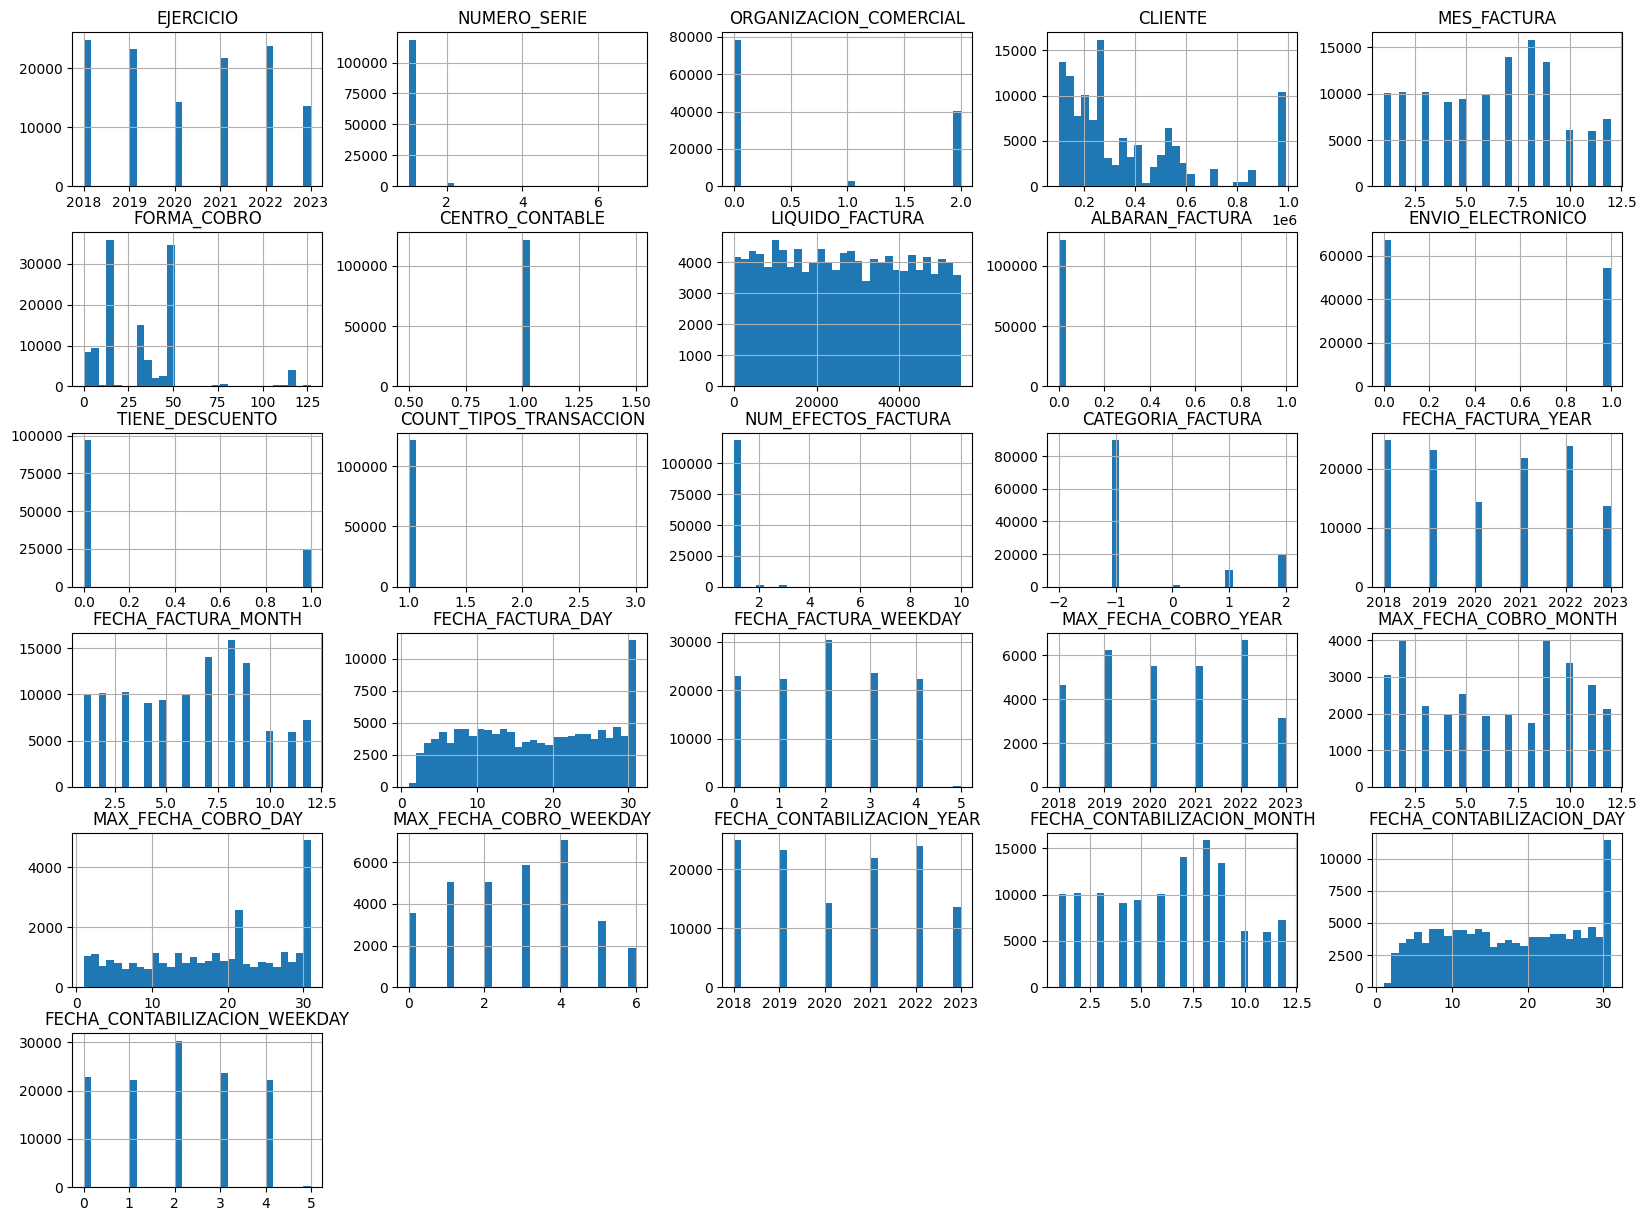

In [12]:

# Distribuciones de las características
data.hist(bins=30, figsize=(20, 15))
plt.show()


In [13]:

# Análisis de valores nulos
print("\nValores nulos en el dataset:")
data.isnull().sum()



Valores nulos en el dataset:


EJERCICIO                            0
NUMERO_SERIE                         0
ORGANIZACION_COMERCIAL               0
CLIENTE                              0
MES_FACTURA                          0
FORMA_COBRO                          0
CENTRO_CONTABLE                      0
LIQUIDO_FACTURA                      0
ALBARAN_FACTURA                      0
ENVIO_ELECTRONICO                    0
TIENE_DESCUENTO                      0
COUNT_TIPOS_TRANSACCION              0
NUM_EFECTOS_FACTURA                  0
CATEGORIA_FACTURA                    0
FECHA_FACTURA_YEAR                   0
FECHA_FACTURA_MONTH                  0
FECHA_FACTURA_DAY                    0
FECHA_FACTURA_WEEKDAY                0
MAX_FECHA_COBRO_YEAR             89820
MAX_FECHA_COBRO_MONTH            89820
MAX_FECHA_COBRO_DAY              89820
MAX_FECHA_COBRO_WEEKDAY          89820
FECHA_CONTABILIZACION_YEAR           0
FECHA_CONTABILIZACION_MONTH          0
FECHA_CONTABILIZACION_DAY            0
FECHA_CONTABILIZACION_WEE

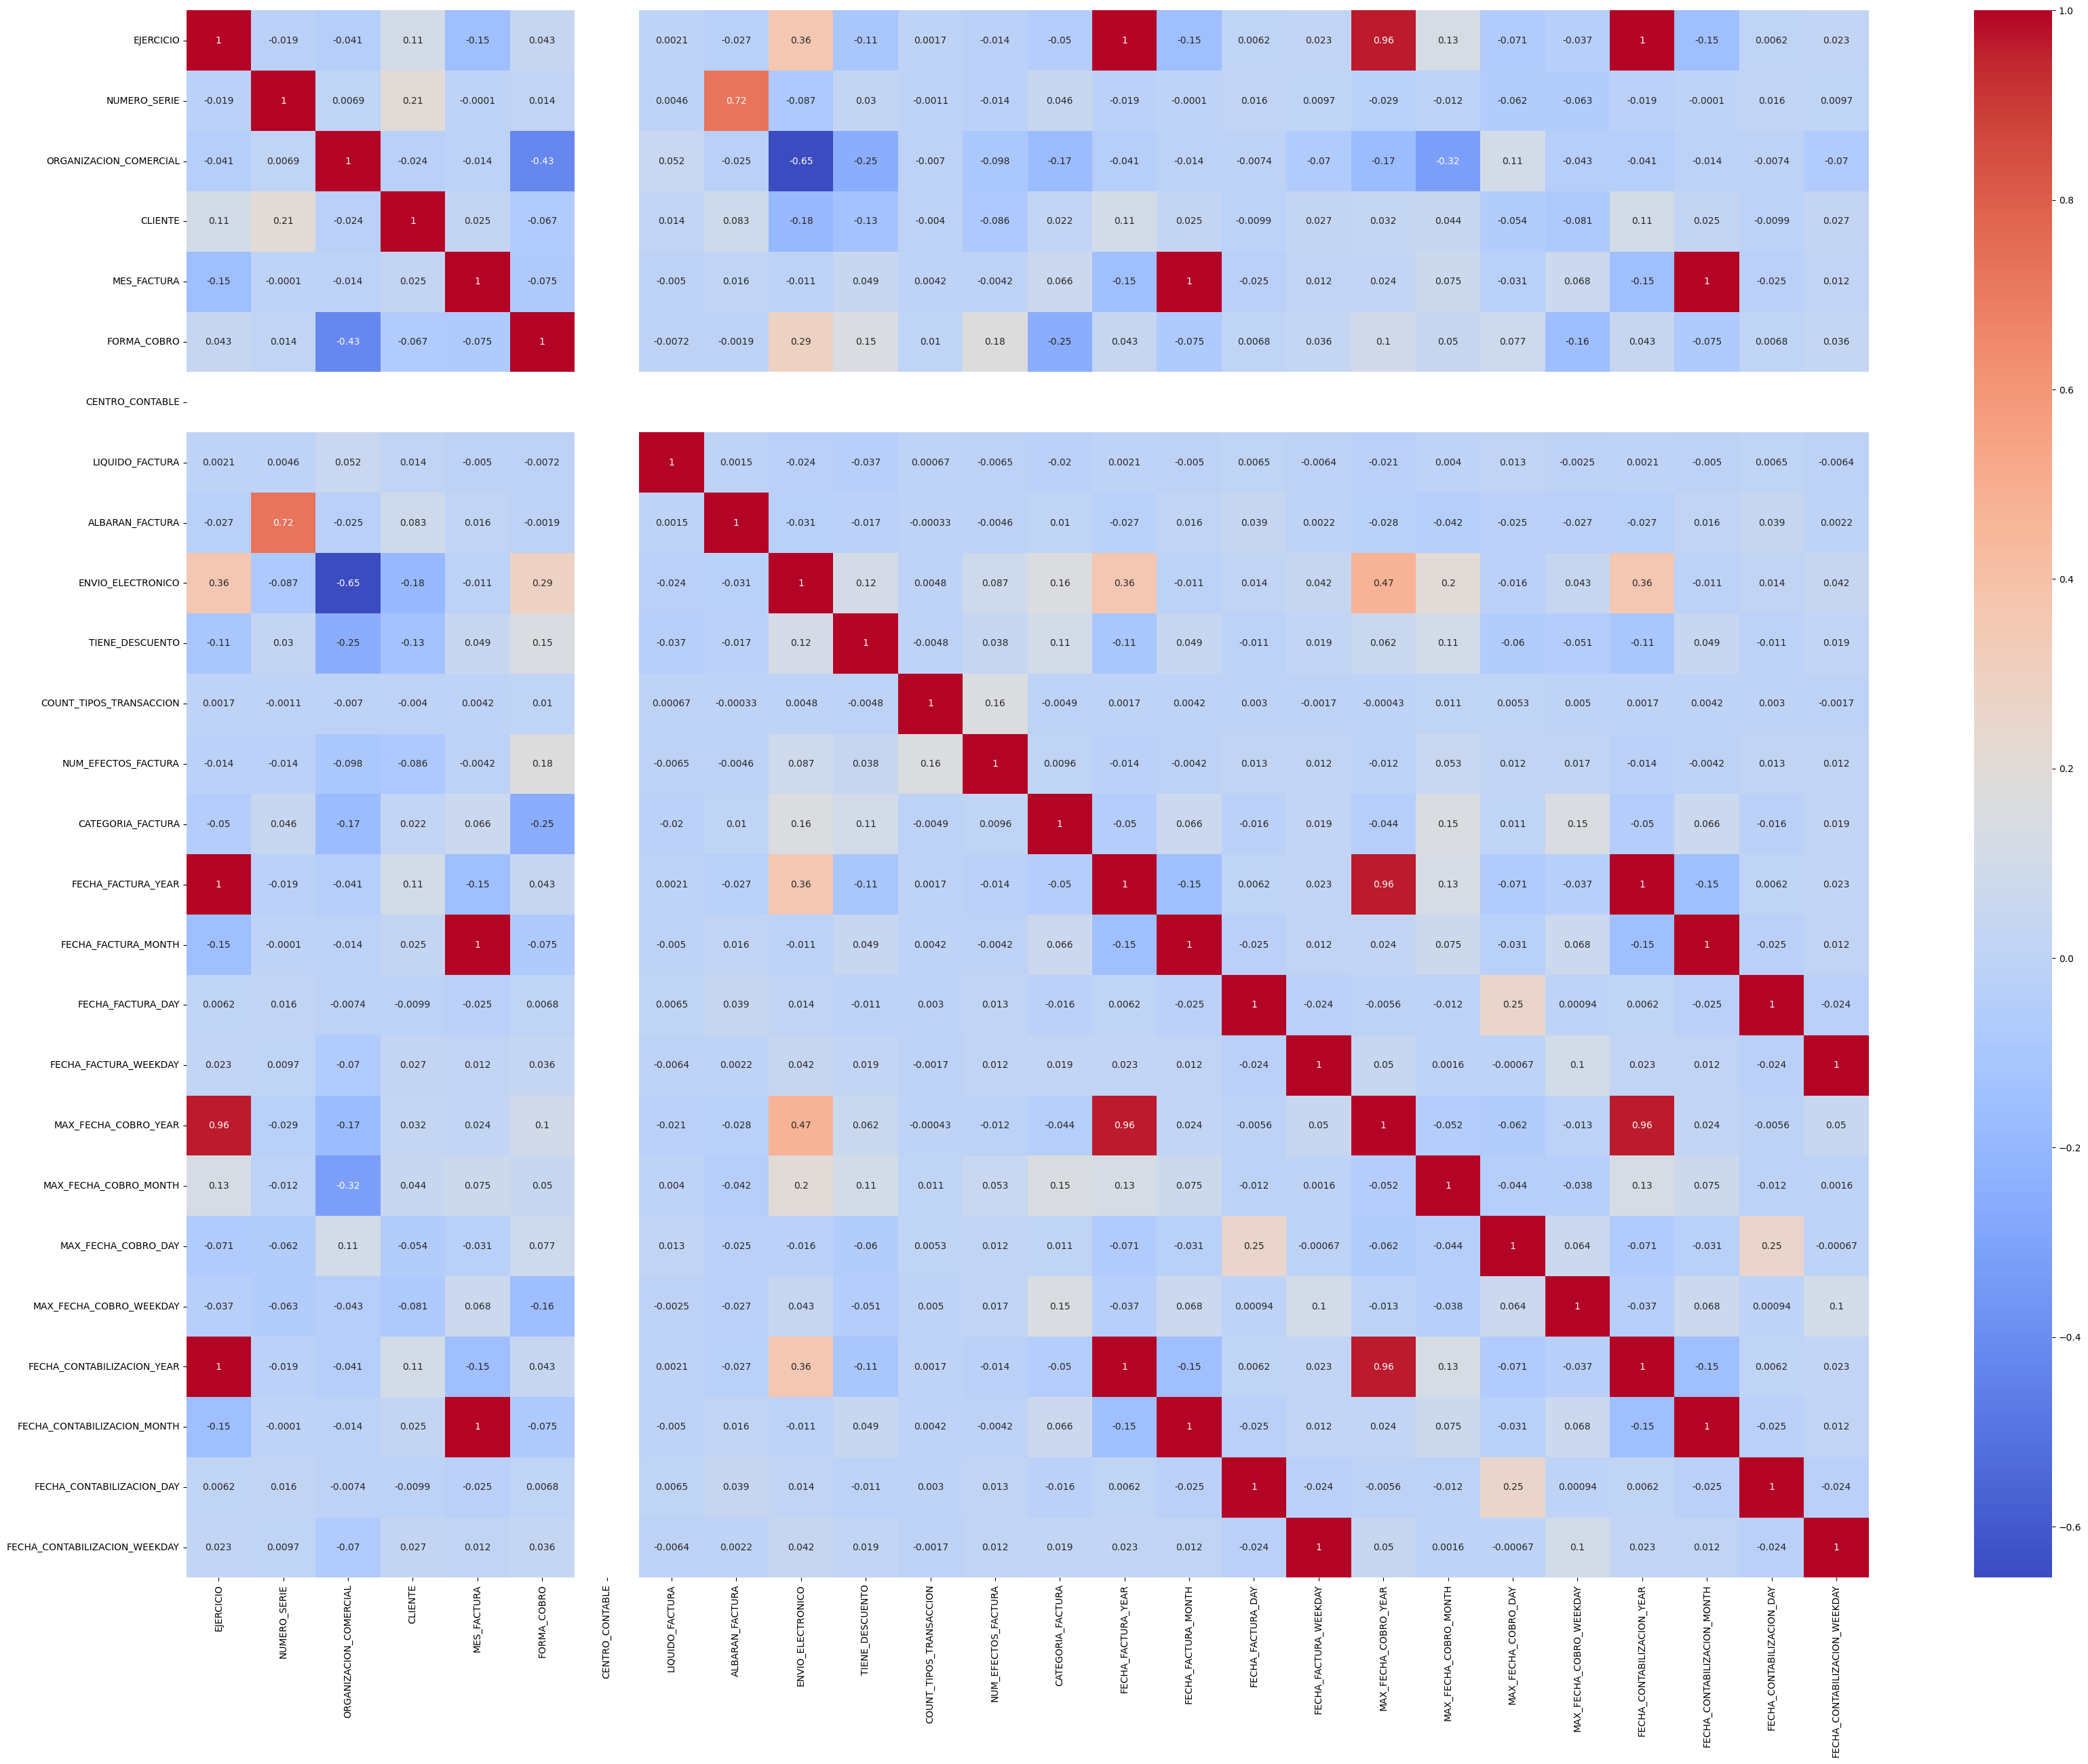

In [14]:
# Correlaciones entre las características
plt.figure(figsize=(40, 30))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.show()

In [15]:

# Manejo de valores nulos
data.fillna(data.mean(), inplace=True)


In [16]:

# Separación de características y variable objetivo
X = data.drop('CATEGORIA_FACTURA', axis=1)
#y = data['CATEGORIA_FACTURA']
# Re-codificar las clases de la variable objetivo
label_encoder_y = LabelEncoder()
y = label_encoder_y.fit_transform(data['CATEGORIA_FACTURA'])


In [17]:

# División de los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [18]:

# Estandarización de las características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [19]:

# Entrenamiento y Validación de Modelos de Clasificación

# Árboles de Decisión
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
print("\nÁrboles de Decisión:")
print(classification_report(y_test, y_pred_dt))
print(confusion_matrix(y_test, y_pred_dt))



Árboles de Decisión:
              precision    recall  f1-score   support

           0       0.11      0.10      0.11        10
           1       1.00      1.00      1.00     17924
           2       0.27      0.24      0.25       215
           3       0.83      0.83      0.83      2148
           4       0.91      0.92      0.91      4004

    accuracy                           0.96     24301
   macro avg       0.63      0.62      0.62     24301
weighted avg       0.96      0.96      0.96     24301

[[    1     0     0     2     7]
 [    0 17865    32     7    20]
 [    0    32    51    79    53]
 [    2     7    73  1787   279]
 [    6    19    30   273  3676]]


In [20]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42, criterion='gini', max_features='sqrt')
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("\nRandom Forest:")
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))


Random Forest:
              precision    recall  f1-score   support

           0       1.00      0.10      0.18        10
           1       1.00      1.00      1.00     17924
           2       0.53      0.13      0.20       215
           3       0.86      0.87      0.86      2148
           4       0.92      0.95      0.93      4004

    accuracy                           0.97     24301
   macro avg       0.86      0.61      0.64     24301
weighted avg       0.97      0.97      0.97     24301

[[    1     0     0     0     9]
 [    0 17890     2     2    30]
 [    0    42    27   101    45]
 [    0     0    21  1873   254]
 [    0     0     1   208  3795]]


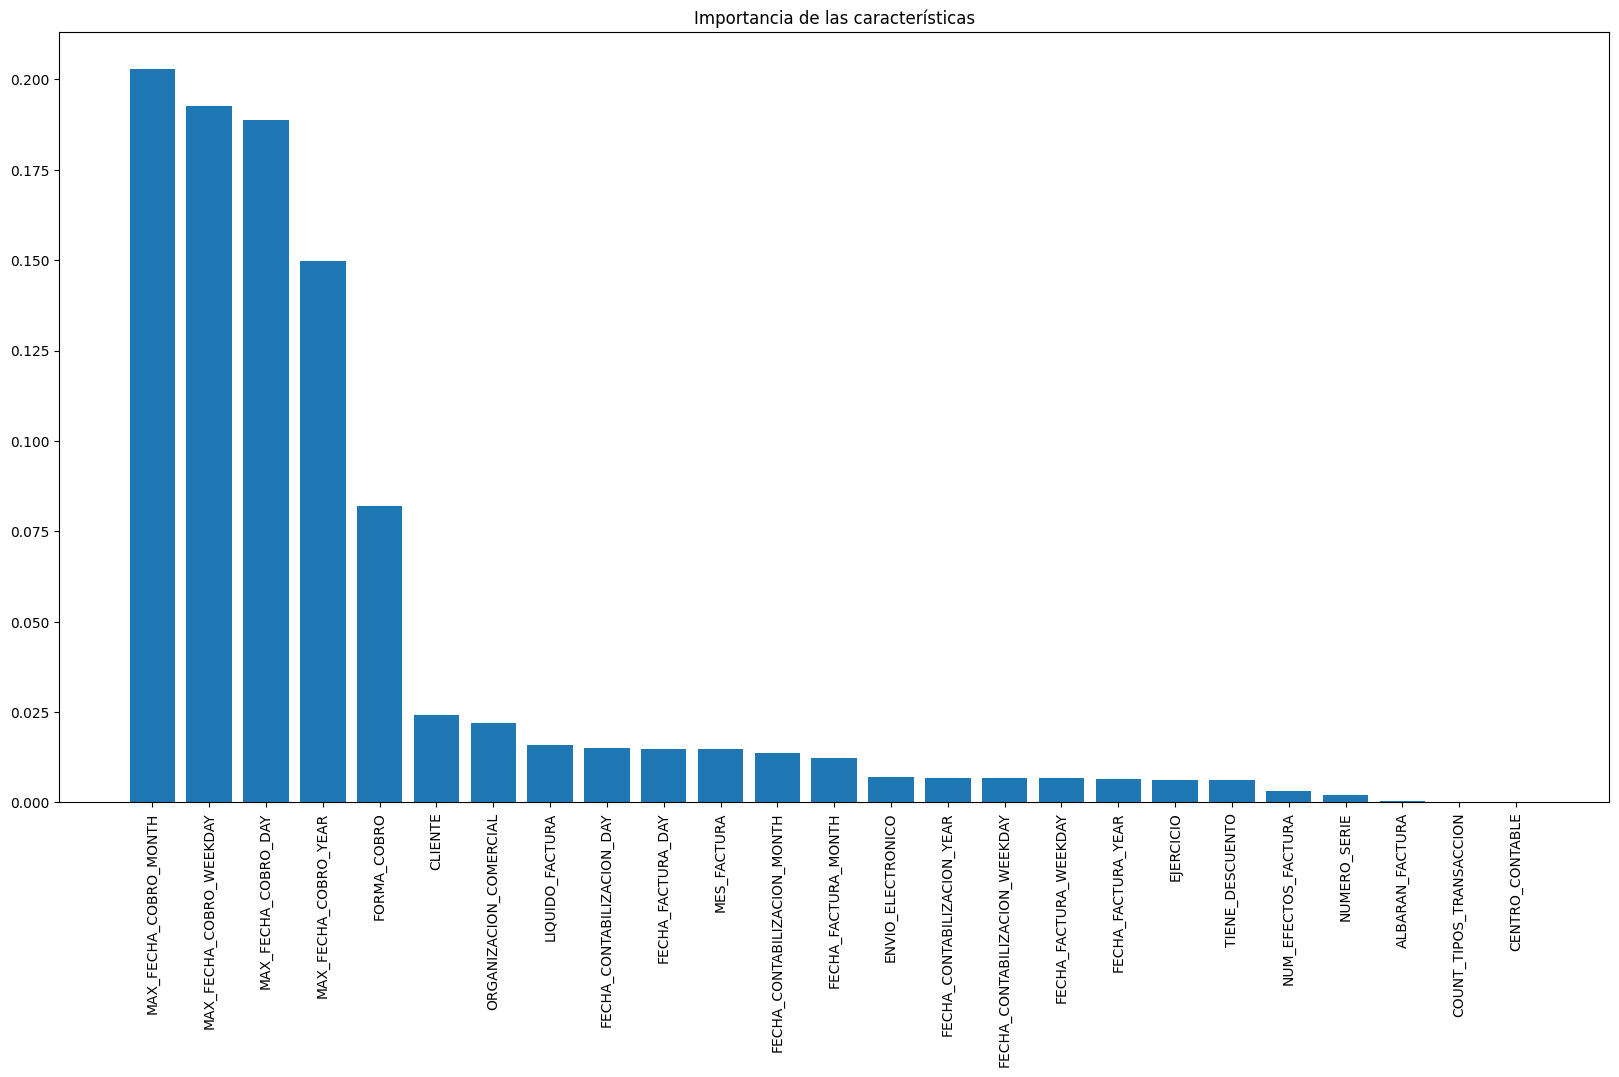

In [21]:
#revisamos la importancia de cada feature
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns
plt.figure(figsize=(20, 10))
plt.title("Importancia de las características")
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
plt.show()

In [22]:
# evaluamos el modelo random forest
print("Accuracy: ", accuracy_score(y_test, y_pred_rf))

# evaluamos el sobreajuste
y_pred_train_rf = rf.predict(X_train)
print("Accuracy Train: ", accuracy_score(y_train, y_pred_train_rf))


Accuracy:  0.9705773424961935
Accuracy Train:  0.9999588490067179


In [23]:
# Support Vector Machine
svm = SVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
print("\nSupport Vector Machine:")
print(classification_report(y_test, y_pred_svm))
print(confusion_matrix(y_test, y_pred_svm))


Support Vector Machine:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       1.00      1.00      1.00     17924
           2       0.52      0.06      0.11       215
           3       0.82      0.81      0.82      2148
           4       0.88      0.93      0.91      4004

    accuracy                           0.96     24301
   macro avg       0.64      0.56      0.57     24301
weighted avg       0.96      0.96      0.96     24301

[[    0     2     1     1     6]
 [    0 17889     4     5    26]
 [    0    47    13    95    60]
 [    0    10     4  1735   399]
 [    0     7     3   273  3721]]


/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

In [24]:
# evaluamos el modelo svm
print("Accuracy: ", accuracy_score(y_test, y_pred_svm))

Accuracy:  0.9611950125509239


In [25]:
# XGBoost
xgboost = xgb.XGBClassifier()
xgboost.fit(X_train, y_train)
y_pred_xgb = xgboost.predict(X_test)
print("\nXGBoost:")
print(classification_report(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))


XGBoost:
              precision    recall  f1-score   support

           0       1.00      0.10      0.18        10
           1       1.00      1.00      1.00     17924
           2       0.63      0.20      0.30       215
           3       0.86      0.89      0.87      2148
           4       0.93      0.95      0.94      4004

    accuracy                           0.97     24301
   macro avg       0.88      0.63      0.66     24301
weighted avg       0.97      0.97      0.97     24301

[[    1     0     0     1     8]
 [    0 17888     5     2    29]
 [    0    39    42    98    36]
 [    0     0    16  1904   228]
 [    0     0     4   202  3798]]


In [46]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
knn = KNeighborsClassifier(metric='manhattan', n_neighbors=5, weights='distance')
'''
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

grid_knn = GridSearchCV(knn, param_grid_knn, refit=True, verbose=2)
grid_knn.fit(X_train, y_train)

print("\nMejores hiperparámetros para K-NN:")
print(grid_knn.best_params_)

y_pred_knn = label_encoder_y.inverse_transform(grid_knn.predict(X_test))
'''


'\nparam_grid_knn = {\n    \'n_neighbors\': [3, 5, 7, 9, 11],\n    \'weights\': [\'uniform\', \'distance\'],\n    \'metric\': [\'euclidean\', \'manhattan\', \'minkowski\']\n}\n\ngrid_knn = GridSearchCV(knn, param_grid_knn, refit=True, verbose=2)\ngrid_knn.fit(X_train, y_train)\n\nprint("\nMejores hiperparámetros para K-NN:")\nprint(grid_knn.best_params_)\n\ny_pred_knn = label_encoder_y.inverse_transform(grid_knn.predict(X_test))\n'

In [47]:
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
print("\nK-NN:")
print(classification_report(y_test, y_pred_knn))
print(confusion_matrix(y_test, y_pred_knn))



K-NN:
              precision    recall  f1-score   support

           0       0.50      0.10      0.17        10
           1       0.99      1.00      0.99     17924
           2       0.38      0.13      0.19       215
           3       0.87      0.79      0.83      2148
           4       0.90      0.94      0.92      4004

    accuracy                           0.96     24301
   macro avg       0.73      0.59      0.62     24301
weighted avg       0.96      0.96      0.96     24301

[[    1     5     0     0     4]
 [    0 17889     5     1    29]
 [    0    61    28    71    55]
 [    0    76    30  1707   335]
 [    1    49    11   173  3770]]


In [48]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score

In [49]:
def evaluate_model(name, model, X_test, y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"\n{name}:")
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    return [name, accuracy, precision, recall, f1]

results = []

In [50]:
results.append(evaluate_model("K-Nearest Neighbors", knn, X_test, y_test, y_pred_knn))


K-Nearest Neighbors:
              precision    recall  f1-score   support

           0       0.50      0.10      0.17        10
           1       0.99      1.00      0.99     17924
           2       0.38      0.13      0.19       215
           3       0.87      0.79      0.83      2148
           4       0.90      0.94      0.92      4004

    accuracy                           0.96     24301
   macro avg       0.73      0.59      0.62     24301
weighted avg       0.96      0.96      0.96     24301

[[    1     5     0     0     4]
 [    0 17889     5     1    29]
 [    0    61    28    71    55]
 [    0    76    30  1707   335]
 [    1    49    11   173  3770]]


In [51]:
results.append(evaluate_model("Árboles de Decisión", dt, X_test, y_test, y_pred_dt))


Árboles de Decisión:
              precision    recall  f1-score   support

           0       0.11      0.10      0.11        10
           1       1.00      1.00      1.00     17924
           2       0.27      0.24      0.25       215
           3       0.83      0.83      0.83      2148
           4       0.91      0.92      0.91      4004

    accuracy                           0.96     24301
   macro avg       0.63      0.62      0.62     24301
weighted avg       0.96      0.96      0.96     24301

[[    1     0     0     2     7]
 [    0 17865    32     7    20]
 [    0    32    51    79    53]
 [    2     7    73  1787   279]
 [    6    19    30   273  3676]]


In [52]:
results.append(evaluate_model("Random Forest", rf, X_test, y_test, y_pred_rf))


Random Forest:
              precision    recall  f1-score   support

           0       1.00      0.10      0.18        10
           1       1.00      1.00      1.00     17924
           2       0.53      0.13      0.20       215
           3       0.86      0.87      0.86      2148
           4       0.92      0.95      0.93      4004

    accuracy                           0.97     24301
   macro avg       0.86      0.61      0.64     24301
weighted avg       0.97      0.97      0.97     24301

[[    1     0     0     0     9]
 [    0 17890     2     2    30]
 [    0    42    27   101    45]
 [    0     0    21  1873   254]
 [    0     0     1   208  3795]]


In [53]:
results.append(evaluate_model("Support Vector Machine", svm, X_test, y_test, y_pred_svm))


Support Vector Machine:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       1.00      1.00      1.00     17924
           2       0.52      0.06      0.11       215
           3       0.82      0.81      0.82      2148
           4       0.88      0.93      0.91      4004

    accuracy                           0.96     24301
   macro avg       0.64      0.56      0.57     24301
weighted avg       0.96      0.96      0.96     24301

[[    0     2     1     1     6]
 [    0 17889     4     5    26]
 [    0    47    13    95    60]
 [    0    10     4  1735   399]
 [    0     7     3   273  3721]]


/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

In [54]:
results.append(evaluate_model("XGBoost", xgboost, X_test, y_test, y_pred_xgb))


XGBoost:
              precision    recall  f1-score   support

           0       1.00      0.10      0.18        10
           1       1.00      1.00      1.00     17924
           2       0.63      0.20      0.30       215
           3       0.86      0.89      0.87      2148
           4       0.93      0.95      0.94      4004

    accuracy                           0.97     24301
   macro avg       0.88      0.63      0.66     24301
weighted avg       0.97      0.97      0.97     24301

[[    1     0     0     1     8]
 [    0 17888     5     2    29]
 [    0    39    42    98    36]
 [    0     0    16  1904   228]
 [    0     0     4   202  3798]]



Tabla de comparación de modelos:
                   Modelo  Exactitud  Precisión    Recall  F1-Score
0     K-Nearest Neighbors   0.962718   0.958786  0.962718  0.959899
1     Árboles de Decisión   0.962100   0.961311  0.962100  0.961691
2           Random Forest   0.970577   0.968047  0.970577  0.968015
3  Support Vector Machine   0.961195   0.957748  0.961195  0.957760
4                 XGBoost   0.972511   0.970860  0.972511  0.970497


<Figure size 1300x800 with 0 Axes>

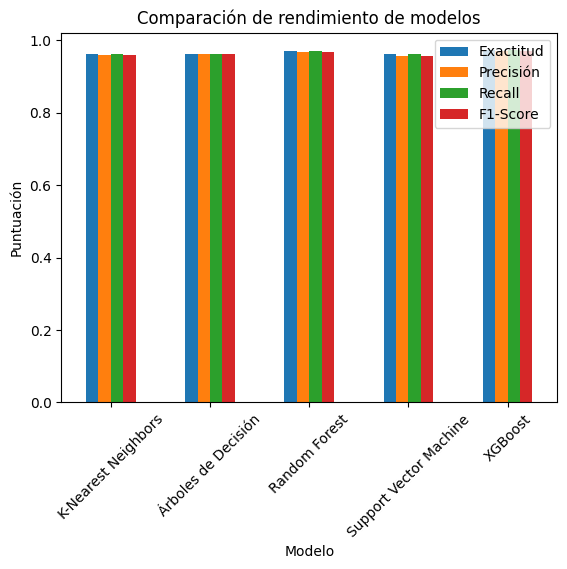

In [57]:
# Crear un DataFrame con los resultados
results_df = pd.DataFrame(results, columns=["Modelo", "Exactitud", "Precisión", "Recall", "F1-Score"])

# Mostrar la tabla de resultados
print("\nTabla de comparación de modelos:")
print(results_df)

# Graficar los resultados
plt.figure(figsize=(13, 8))
results_df.set_index("Modelo").plot(kind='bar')
plt.title('Comparación de rendimiento de modelos')
plt.ylabel('Puntuación')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.show()